In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

width, height = 10, 5
mpl.rcParams['figure.figsize'] = [width, height]


In [2]:
from sklearn import svm
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import model_selection

from utility_fns import payout_from_bid
from utility_fns import form_last_n_games
from utility_fns import make_train_val_test


In [3]:
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier


In [4]:
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, metrics, cv


In [5]:
from catboost.utils import get_gpu_device_count

use_gpu = False
if get_gpu_device_count():
    use_gpu = True


In [6]:
# Global notebook params (speed processing of stuff we want only once)
use_years_as_weights = True

do_manual_svc = True
do_manual_bagging = True
do_sklearn_grid_tree = True
do_xgboost = True
do_catboost = True


In [7]:
basedir = os.path.dirname(os.getcwd())
data = os.path.join(basedir, 'data', 'derived', 'cleaned_matches.csv')
defense = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'DEFENSE_stats.csv')
snaps = os.path.join(basedir, 'data', 'derived', 'stats_categories', 'SNAP_COUNTS_stats.csv')

cleaned_matches = pd.read_csv(data)
# defense_stats = pd.read_csv(defense, index_col=[0,1,2])
# snaps_stats = pd.read_csv(snaps, index_col=[0,1,2])

In [8]:
cleaned_matches.Date = pd.to_datetime(cleaned_matches.Date)
cleaned_matches.sort_values(by='Date', inplace=True, ascending=True)
cleaned_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31824 entries, 0 to 31823
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Day             31824 non-null  object        
 1   Date            31824 non-null  datetime64[ns]
 2   Home/Away       31824 non-null  object        
 3   Opponent        31824 non-null  object        
 4   Score           31824 non-null  object        
 5   W/L/T           31824 non-null  object        
 6   Overtime        1089 non-null   object        
 7   Location        31824 non-null  object        
 8   Venue           31823 non-null  object        
 9   Attendance      31506 non-null  float64       
 10  Notes           1306 non-null   object        
 11  Opponent Code   31824 non-null  object        
 12  Team            31824 non-null  object        
 13  Team Code       31824 non-null  object        
 14  Team Score      31606 non-null  float64       
 15  Op

In [9]:
cleaned_matches['Pct Team Score'] = cleaned_matches['Team Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])
cleaned_matches['Pct Opponent Score'] = cleaned_matches['Opponent Score'] / \
    (cleaned_matches['Team Score'] + cleaned_matches['Opponent Score'])

oldest_match_year = np.min(cleaned_matches['Date'].dt.year)

cleaned_matches['Weight'] = (cleaned_matches['Date'].dt.year - oldest_match_year
                             ) if use_years_as_weights else np.ones(cleaned_matches['Date'].shape)


## Train to classify based on the last-n-games a team played

In [10]:
x_cols = [
    'Team Code',
    'Opponent Code',
    'Home/Away'
]
lookup_x_cols = [
    'Team Score',
    'Opponent Score',
    'Score Diff',
    'Pct Team Score',
    'Pct Opponent Score',
    'Home/Away'
]
key_x_cols = [
    'Team Code',
    'Opponent Code'
]
weight_cols = [
    'Weight'
]
y_cols = [
    'Class'
]

played_matches = cleaned_matches.dropna(
    axis=0, how='any', subset=x_cols + y_cols + lookup_x_cols).copy()

played_matches['Class'].where(
    played_matches['Class'] > 0, other=0, inplace=True)


played_matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31474 entries, 0 to 31823
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Day                 31474 non-null  object        
 1   Date                31474 non-null  datetime64[ns]
 2   Home/Away           31474 non-null  object        
 3   Opponent            31474 non-null  object        
 4   Score               31474 non-null  object        
 5   W/L/T               31474 non-null  object        
 6   Overtime            1089 non-null   object        
 7   Location            31474 non-null  object        
 8   Venue               31473 non-null  object        
 9   Attendance          31174 non-null  float64       
 10  Notes               1288 non-null   object        
 11  Opponent Code       31474 non-null  object        
 12  Team                31474 non-null  object        
 13  Team Code           31474 non-null  object    

In [11]:
def dataset_transformer():
    return ColumnTransformer([('scaler', StandardScaler(), numeric_columns), ('one-hot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])


In [12]:
last_n_matches, new_columns = form_last_n_games(
    played_matches, 5, lookup_x_cols, key_x_cols)


.................................................
 Done


In [51]:
X = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y = last_n_matches[y_cols]
weights = played_matches[weight_cols].loc[last_n_matches.index,:]

numeric_columns = X.columns[X.columns.str.contains('Score')]
categorical_columns = X.columns[~X.columns.str.contains('Score')]
categorical_columns_indices = np.where(~X.columns.str.contains('Score'))[0]

print(categorical_columns)
print(categorical_columns_indices)
print(numeric_columns)
print(weights)


Index(['Team Code', 'Opponent Code', 'Home/Away', 'Team Code_p_Home/Away',
       'Opponent Code_p_Home/Away', 'Team Code_pp_Home/Away',
       'Opponent Code_pp_Home/Away', 'Team Code_ppp_Home/Away',
       'Opponent Code_ppp_Home/Away', 'Team Code_pppp_Home/Away',
       'Opponent Code_pppp_Home/Away', 'Team Code_ppppp_Home/Away',
       'Opponent Code_ppppp_Home/Away'],
      dtype='object')
[ 0  1  2 53 54 55 56 57 58 59 60 61 62]
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
       'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
       'Team Code_p_Opponent Score', 'Opponent Code_p_Opponent Score',
       'Team Code_pp_Opponent Score', 'Opponent Code_pp_Opponent Score',
       'Team Code_ppp_Opponent Score', 'Opponent Code_ppp_Opponent Score',
       

In [52]:
X.head()


,Team Code,Opponent Code,Home/Away,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,...,Team Code_p_Home/Away,Opponent Code_p_Home/Away,Team Code_pp_Home/Away,Opponent Code_pp_Home/Away,Team Code_ppp_Home/Away,Opponent Code_ppp_Home/Away,Team Code_pppp_Home/Away,Opponent Code_pppp_Home/Away,Team Code_ppppp_Home/Away,Opponent Code_ppppp_Home/Away
35,cle,col,H,0.0,0.0,0.0,0.0,7.0,6.0,7.0,...,A,A,A,A,H,H,H,A,A,H
32,can,akr,H,10.0,10.0,20.0,0.0,20.0,7.0,7.0,...,A,A,A,A,H,H,H,A,A,H
34,chit,ri,A,20.0,20.0,0.0,0.0,10.0,7.0,12.0,...,H,H,H,A,A,H,H,A,A,H
40,can,cle,A,0.0,7.0,10.0,0.0,20.0,0.0,20.0,...,H,H,A,A,A,A,H,H,H,H
42,chit,chic,H,6.0,6.0,7.0,21.0,20.0,0.0,0.0,...,A,A,A,H,H,A,H,A,A,H


In [53]:
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31016 entries, 35 to 31823
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Team Code                               31016 non-null  object 
 1   Opponent Code                           31016 non-null  object 
 2   Home/Away                               31016 non-null  object 
 3   Team Code_p_Team Score                  31016 non-null  float64
 4   Opponent Code_p_Team Score              31016 non-null  float64
 5   Team Code_pp_Team Score                 31016 non-null  float64
 6   Opponent Code_pp_Team Score             31016 non-null  float64
 7   Team Code_ppp_Team Score                31016 non-null  float64
 8   Opponent Code_ppp_Team Score            31016 non-null  float64
 9   Team Code_pppp_Team Score               31016 non-null  float64
 10  Opponent Code_pppp_Team Score           31016 non-null  f

In [54]:
X.corr()


,Team Code_p_Team Score,Opponent Code_p_Team Score,Team Code_pp_Team Score,Opponent Code_pp_Team Score,Team Code_ppp_Team Score,Opponent Code_ppp_Team Score,Team Code_pppp_Team Score,Opponent Code_pppp_Team Score,Team Code_ppppp_Team Score,Opponent Code_ppppp_Team Score,...,Team Code_p_Pct Opponent Score,Opponent Code_p_Pct Opponent Score,Team Code_pp_Pct Opponent Score,Opponent Code_pp_Pct Opponent Score,Team Code_ppp_Pct Opponent Score,Opponent Code_ppp_Pct Opponent Score,Team Code_pppp_Pct Opponent Score,Opponent Code_pppp_Pct Opponent Score,Team Code_ppppp_Pct Opponent Score,Opponent Code_ppppp_Pct Opponent Score
Team Code_p_Team Score,1.000000,0.536631,0.053856,0.095852,0.115672,0.110010,0.097558,0.088746,0.114208,0.106801,...,-0.635426,-0.311932,3.149807e-01,0.007829,-0.012139,-0.013522,0.014411,0.008884,-0.012031,-0.006376
Opponent Code_p_Team Score,0.536631,1.000000,0.096122,0.055136,0.099458,0.116796,0.080698,0.104054,0.092346,0.121149,...,-0.314190,-0.635093,2.255570e-03,0.324440,-0.009752,-0.010366,0.013992,0.002059,-0.009676,-0.011980
Team Code_pp_Team Score,0.053856,0.096122,1.000000,0.082605,0.051632,0.082957,0.116600,0.100224,0.099409,0.077384,...,0.315253,-0.000324,-6.375959e-01,0.004579,0.326035,0.012464,-0.010298,-0.019611,0.006155,0.012768
Opponent Code_pp_Team Score,0.095852,0.055136,0.082605,1.000000,0.087585,0.057662,0.086239,0.117260,0.078543,0.102933,...,-0.000208,0.315587,6.819216e-03,-0.634620,-0.004178,0.317578,-0.000696,-0.010073,0.004641,0.008481
Team Code_ppp_Team Score,0.115672,0.099458,0.051632,0.087585,1.000000,0.094886,0.059950,0.086008,0.119964,0.077689,...,-0.009165,-0.003341,3.198356e-01,-0.001386,-0.635915,-0.003095,0.318339,0.004255,-0.012047,0.004225
Opponent Code_ppp_Team Score,0.110010,0.116796,0.082957,0.057662,0.094886,1.000000,0.081350,0.051708,0.102511,0.113203,...,-0.011103,-0.006116,1.525528e-03,0.312922,-0.005622,-0.633790,0.021327,0.320885,-0.015473,-0.007276
Team Code_pppp_Team Score,0.097558,0.080698,0.116600,0.086239,0.059950,0.081350,1.000000,0.105934,0.060954,0.078046,...,0.013056,0.009772,-5.530736e-03,-0.005330,0.308727,0.013109,-0.631000,-0.017293,0.318548,0.012603
Opponent Code_pppp_Team Score,0.088746,0.104054,0.100224,0.117260,0.086008,0.051708,0.105934,1.000000,0.090485,0.049774,...,0.012128,0.003607,-1.350969e-02,-0.011781,0.006149,0.321357,-0.010608,-0.637093,0.005913,0.322711
Team Code_ppppp_Team Score,0.114208,0.092346,0.099409,0.078543,0.119964,0.102511,0.060954,0.090485,1.000000,0.104750,...,-0.009972,-0.001335,9.148002e-03,0.011282,-0.011245,-0.008161,0.323319,0.002050,-0.635831,-0.012291
Opponent Code_ppppp_Team Score,0.106801,0.121149,0.077384,0.102933,0.077689,0.113203,0.078046,0.049774,0.104750,1.000000,...,-0.009116,-0.009943,1.352309e-03,0.005636,-0.006619,-0.004656,0.013137,0.310377,-0.009956,-0.633342


In [55]:
y.head()


,Class
35,1
32,0
34,0
40,1
42,0


In [56]:
last_1_pct = len(X) - len(X)//20
X_chrono_test, X = X.iloc[last_1_pct:], X.iloc[:last_1_pct]
y_chrono_test, y = y.iloc[last_1_pct:], y.iloc[:last_1_pct]
weight_chrono_test = weights.loc[X_chrono_test.index,:]
weights = weights.drop(X_chrono_test.index)

X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(
    X, y, test_pct=0.2, val_pct=0.2, random_state=0
)

weight_train = weights.loc[X_train.index,:]
weight_val = weights.loc[X_val.index,:]
weight_test = weights.loc[X_test.index,:]

print(X.shape, y.shape, weights.shape)
print(X_train.shape, y_train.shape, weight_train.shape)
print(X_val.shape, y_val.shape, weight_val.shape)
print(X_test.shape, y_test.shape, weight_test.shape)
print(X_chrono_test.shape, y_chrono_test.shape, weight_chrono_test.shape)


(29466, 63) (29466, 1) (29466, 1)
(17679, 63) (17679, 1) (17679, 1)
(5893, 63) (5893, 1) (5893, 1)
(5894, 63) (5894, 1) (5894, 1)
(1550, 63) (1550, 1) (1550, 1)


In [19]:
X_cv = pd.concat([X_train, X_val])
y_cv = pd.concat([y_train, y_val])
weight_cv = pd.concat([weight_train, weight_val])

Evaluating linear kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating linear kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


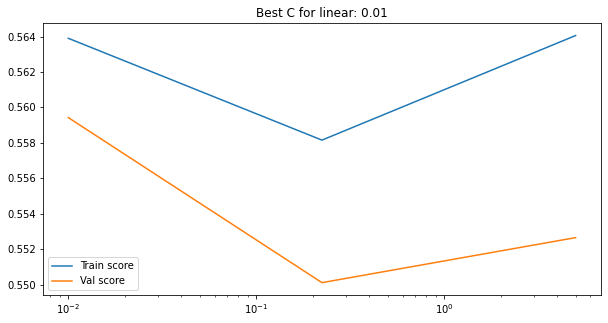

Evaluating poly kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating poly kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating poly kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


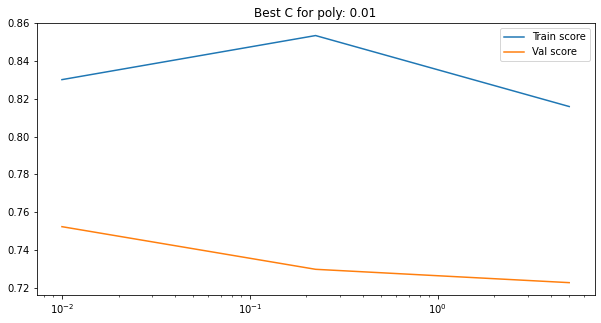

Evaluating rbf kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating rbf kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating rbf kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


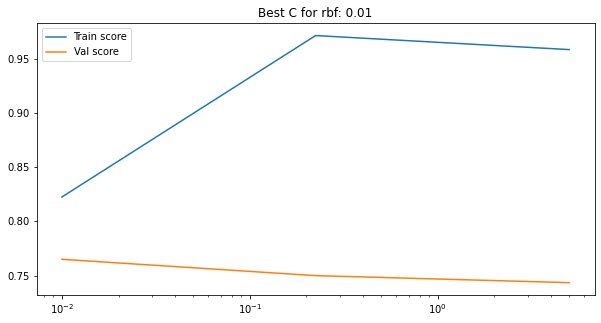

Evaluating sigmoid kernel for C=0.01


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating sigmoid kernel for C=0.22360679774997896


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Evaluating sigmoid kernel for C=5.000000000000001


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


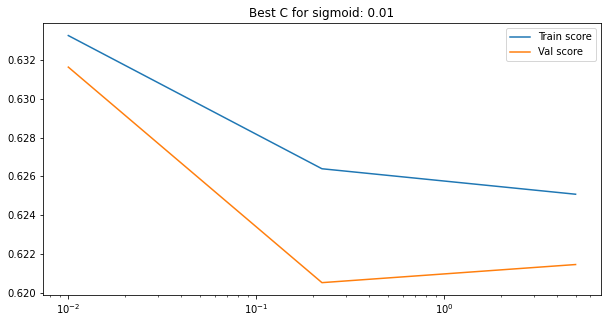

In [20]:
def manual_grid_search_svc(do=True):
    if not do:
        return None
    best_model = None
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        train_scores = []
        val_scores = []
        val_space = np.geomspace(start=0.01, stop=5, num=3)
        for C in val_space:
            print(f"Evaluating {kernel} kernel for C={C}")
            model = make_pipeline(dataset_transformer(), svm.SVC(
                C=C, max_iter=10_000, kernel=kernel))

            model.fit(X_train, y_train.values.ravel(), svc__sample_weight=weight_train.values.ravel())
            train_scores.append(model.score(X_train, y_train.values.ravel(), weight_train.values.ravel()))
            val_scores.append(model.score(X_val, y_val.values.ravel(), weight_val.values.ravel()))

            if best_model is None or val_scores[-1] == np.max(val_scores):
                best_model = model

        plt.title(f'Best C for {kernel}: {val_space[np.argmax(val_scores)]}')
        plt.plot(val_space, train_scores, label='Train score')
        plt.plot(val_space, val_scores, label='Val score')
        # plt.ylim(0, 1.1)
        plt.xscale('log')
        plt.legend()
        plt.show()
    return best_model


best_model = manual_grid_search_svc(do_manual_svc)


In [21]:
if best_model is not None:
    y_pred = best_model.predict(X_test)
    precision, recall, fbeta_score, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary')
    print(precision, recall, fbeta_score)


0.6221843003412969 0.620279006464784 0.6212301925370591


In [22]:
def manual_grid_bagging(do=True):
    if not do:
        return [], [], 0, 0
    best_config = []
    best_score = 0
    best_fit_config = []
    best_fit_score = 0
    for estimator in [DecisionTreeClassifier(max_leaf_nodes=3), DecisionTreeClassifier(max_leaf_nodes=5), DecisionTreeClassifier(max_leaf_nodes=10), DecisionTreeClassifier(max_leaf_nodes=50), DecisionTreeClassifier()]:
        for nestimators in [10, 31, 62, 93, 124, 200, 300, 400, 500]:
            for nsamples in [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6]:
                clf = make_pipeline(dataset_transformer(), BaggingClassifier(
                    base_estimator=estimator, n_estimators=nestimators, max_samples=nsamples))
                clf.fit(X_train, y_train.values.ravel(
                ), baggingclassifier__sample_weight=weight_train.values.ravel())

                score = clf.score(X_val, y_val.values.ravel(),
                                  weight_val.values.ravel())
                if(score > best_score):
                    best_config = [estimator, nestimators, nsamples]
                    best_score = score

                score = clf.score(X_train, y_train.values.ravel(),
                                  weight_train.values.ravel())
                if(score > best_fit_score):
                    best_fit_config = [estimator, nestimators, nsamples]
                    best_fit_score = score

                print(end='.')
            print(end='*')
        print(end='#')
    return best_config, best_fit_config, best_score, best_fit_score


best_config, best_fit_config, best_score, best_fit_score = manual_grid_bagging(
    do_manual_bagging)


.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#.......*.......*.......*.......*.......*.......*.......*.......*.......*#

In [23]:
print(f"Best validation: {best_score}, {best_config}")
print(f"Best training: {best_fit_score}, {best_fit_config}")


Best validation: 0.7829379423710691, [DecisionTreeClassifier(max_leaf_nodes=50), 400, 0.6]
Best training: 0.9993921943558369, [DecisionTreeClassifier(), 400, 0.6]


In [24]:
if do_manual_bagging:
    bagging_model = make_pipeline(dataset_transformer(), BaggingClassifier(
        base_estimator=best_config[0], n_estimators=best_config[1], max_samples=best_config[2]))
    bagging_model.fit(X_train, y_train.values.ravel(
    ), baggingclassifier__sample_weight=weight_train.values.ravel())


In [25]:
model = {
    'model': BaggingClassifier,
    'kwargs': {'base_estimator': DecisionTreeClassifier()},
    'cross_vals': 5,
    'param_grid': {
        'bagging_clf__base_estimator__max_leaf_nodes': np.linspace(2, 100, num=5, dtype=int),
        'bagging_clf__max_samples': np.linspace(0.01, 0.8, 5),
        'bagging_clf__n_estimators': np.geomspace(10, 1000, num=5, dtype=int)
    }
}

pipe = Pipeline([('column_transformer', dataset_transformer()),
                 ('bagging_clf', model['model'](**model['kwargs']))])

print(model)

grid_search_bag_tree = model_selection.GridSearchCV(
    pipe, param_grid=model['param_grid'], cv=model['cross_vals'], n_jobs=5, refit=True, verbose=3)


{'model': <class 'sklearn.ensemble._bagging.BaggingClassifier'>, 'kwargs': {'base_estimator': DecisionTreeClassifier()}, 'cross_vals': 5, 'param_grid': {'bagging_clf__base_estimator__max_leaf_nodes': array([  2,  26,  51,  75, 100]), 'bagging_clf__max_samples': array([0.01  , 0.2075, 0.405 , 0.6025, 0.8   ]), 'bagging_clf__n_estimators': array([  10,   31,  100,  316, 1000])}}


In [26]:
if do_sklearn_grid_tree:
    grid_search_bag_tree.fit(X_cv, y_cv.values.ravel(), **{
                             'bagging_clf__sample_weight': weight_cv.values.ravel()})
                             


Fitting 5 folds for each of 125 candidates, totalling 625 fits


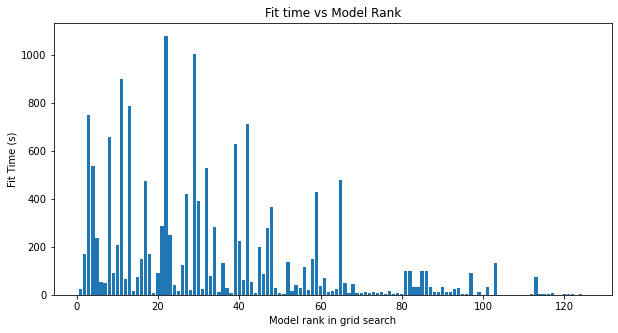

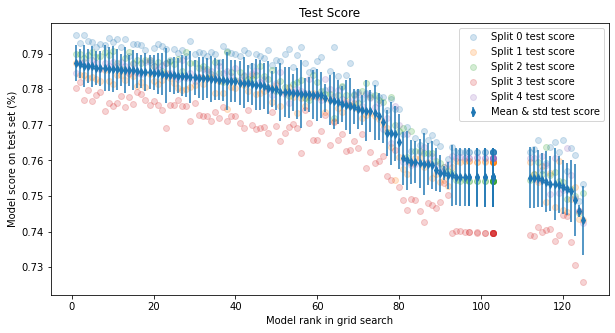

In [27]:
if do_sklearn_grid_tree:
    # print(grid_search_bag_tree.cv_results_.keys())

    x = grid_search_bag_tree.cv_results_['rank_test_score']
    plt.bar(x, grid_search_bag_tree.cv_results_['mean_fit_time'])
    plt.title('Fit time vs Model Rank')
    plt.xlabel('Model rank in grid search')
    plt.ylabel('Fit Time (s)')
    plt.show()

    plt.errorbar(x, grid_search_bag_tree.cv_results_['mean_test_score'], grid_search_bag_tree.cv_results_['std_test_score'], fmt='d', markersize=5, label='Mean & std test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split0_test_score'], alpha=0.2, label='Split 0 test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split1_test_score'], alpha=0.2, label='Split 1 test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split2_test_score'], alpha=0.2, label='Split 2 test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split3_test_score'], alpha=0.2, label='Split 3 test score')
    plt.scatter(x, grid_search_bag_tree.cv_results_['split4_test_score'], alpha=0.2, label='Split 4 test score')
    plt.title('Test Score')
    plt.xlabel('Model rank in grid search')
    plt.ylabel('Model score on test set (%)')
    plt.legend()
    plt.show()

In [28]:
if do_sklearn_grid_tree:
  print(
      f"Test score={grid_search_bag_tree.best_estimator_.score(X_test,y_test.values.ravel(), weight_test.values.ravel())}")
  print(
      f"Chronological test score={grid_search_bag_tree.best_estimator_.score(X_chrono_test, y_chrono_test.values.ravel(), weight_chrono_test.values.ravel())}")


Test score=0.7726821174555869
Chronological test score=0.6955374750231811


Scores for last 5% of games=0.6967741935483871


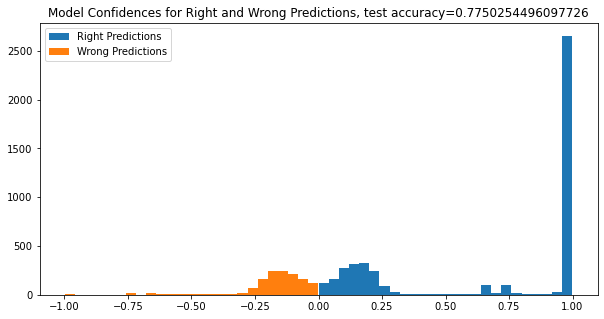

In [30]:
if do_sklearn_grid_tree:
    confidences = grid_search_bag_tree.best_estimator_.predict_proba(X_test)
    confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
    wrong_preds = confidences[confidences < 0]
    right_preds = confidences[confidences > 0]
    print(f"Scores for last 5% of games={grid_search_bag_tree.best_estimator_.score(X_chrono_test, y_chrono_test)}")
    plt.title(f'Model Confidences for Right and Wrong Predictions, test accuracy={grid_search_bag_tree.best_estimator_.score(X_test, y_test.values.ravel())}')
    plt.hist(right_preds, bins=25, label='Right Predictions')
    plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
    plt.legend()
    plt.show()


In [31]:
clf = make_pipeline(dataset_transformer(), DecisionTreeClassifier())
clf.fit(X_train, y_train.values.ravel(), decisiontreeclassifier__sample_weight=weight_train.values.ravel())
clf.score(X_val, y_val.values.ravel(), weight_val.values.ravel())


0.7497506363759685

Scores for last 5% of games=0.6793548387096774


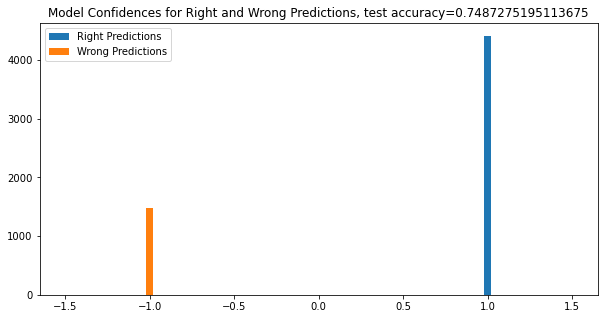

In [32]:
confidences = clf.predict_proba(X_test)
confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
wrong_preds = confidences[confidences < 0]
right_preds = confidences[confidences > 0]
print(f"Scores for last 5% of games={clf.score(X_chrono_test, y_chrono_test.values.ravel())}")
plt.title(f'Model Confidences for Right and Wrong Predictions, test accuracy={clf.score(X_test, y_test.values.ravel())}')
plt.hist(right_preds, bins=25, label='Right Predictions')
plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
plt.legend()
plt.show()


In [33]:
if do_manual_svc:
    Cs = np.geomspace(0.01, 15, num=75)
    scores = []
    for c in Cs:
        model = make_pipeline(dataset_transformer(), svm.LinearSVC(
            dual=False, C=c, max_iter=100_000))
        scores.append(cross_val_score(
            model, X_cv, y_cv.values.ravel(), cv=5, fit_params={'linearsvc__sample_weights': weight_cv.values.ravel()}, n_jobs=-1))
        print(end='.')


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

..

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


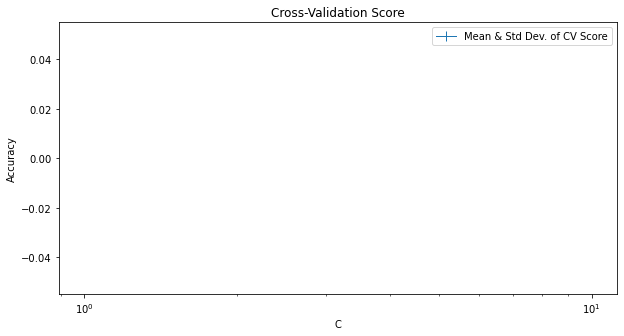

In [34]:
if do_manual_svc:
    x = Cs
    plt.errorbar(x, np.mean(scores, axis=1), np.std(scores, axis=1),
                 label='Mean & Std Dev. of CV Score', linewidth=1)
    plt.plot(x, np.sort(scores, axis=1), linewidth=0.2)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Score')
    plt.show()


In [35]:
if do_manual_svc:
    print('Maximum mean:', np.max(np.mean(scores, axis=1)))
    print('Corresponding std deviation:', np.std(
        scores, axis=1)[np.argmax(np.mean(scores, axis=1))])
    print('C:', Cs[np.argmax(np.mean(scores, axis=1))])


Maximum mean: nan
Corresponding std deviation: nan
C: 0.01


In [36]:
if do_manual_svc:
    print('Minimum std deviation:', np.min(np.std(scores, axis=1)))
    print('Corresponding mean:', np.mean(scores, axis=1)
          [np.argmin(np.std(scores, axis=1))])
    print('C:', Cs[np.argmin(np.std(scores, axis=1))])


Minimum std deviation: nan
Corresponding mean: nan
C: 0.01


In [37]:
if do_manual_svc:
    best_mean_cs = np.flip(np.argsort(np.mean(scores, axis=1)))
    best_std_cs = np.argsort(np.std(scores, axis=1))


In [38]:
if do_manual_svc:
    # Do some random perturbation of the Cs
    scores = []

    Cs_to_examine = np.unique(np.concatenate(
        (Cs[best_mean_cs[:5]], Cs[best_std_cs[:5]])))
    Cs_to_examine = np.unique(np.concatenate([Cs_to_examine, np.abs(
        Cs_to_examine + np.random.normal(scale=0.2, size=len(Cs_to_examine)))]))

    for c in Cs_to_examine:
        model = make_pipeline(dataset_transformer(), svm.LinearSVC(
            dual=False, C=c, max_iter=100_000))

        scores.append(cross_val_score(
            model, X_cv, y_cv.values.ravel(), cv=5, n_jobs=-1, fit_params={'linearsvc__sample_weights': weight_cv.values.ravel()}))

        print(end='.')


C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

.

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

..

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() got an unexpected keyword argument 'sample_weights'

  warnings.warn(some_fits_fai

C:\Users\Eric\anaconda3\envs\machine_learning\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


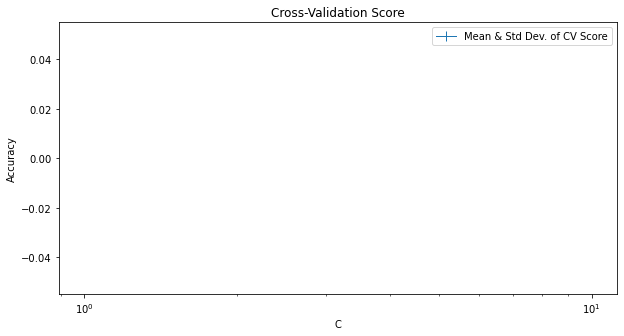

In [39]:
if do_manual_svc:
    x = Cs_to_examine
    quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
    plt.errorbar(x, np.mean(scores, axis=1), np.std(scores, axis=1),
                 label='Mean & Std Dev. of CV Score', linewidth=1)
    plt.plot(x, np.quantile(scores, quantiles, axis=1).T, linewidth=0.2)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Score')
    plt.show()


In [40]:
if do_manual_svc:
    best_mean_idx = np.argmax(np.mean(scores, axis=1))

    print(
        f'Best C={Cs_to_examine[best_mean_idx]} with mean={np.mean(scores,axis=1)[best_mean_idx]}, std={np.std(scores,axis=1)[best_mean_idx]}')


Best C=0.01 with mean=nan, std=nan


In [42]:
if do_manual_svc:
    # Train the best model.

    model = make_pipeline(dataset_transformer(),
                          svm.LinearSVC(dual=False, C=Cs_to_examine[best_mean_idx], max_iter=100_000))
    model.fit(X_cv, y_cv.values.ravel(),
              linearsvc__sample_weight=weight_cv.values.ravel())
    model.score(X_test, y_test.values.ravel())


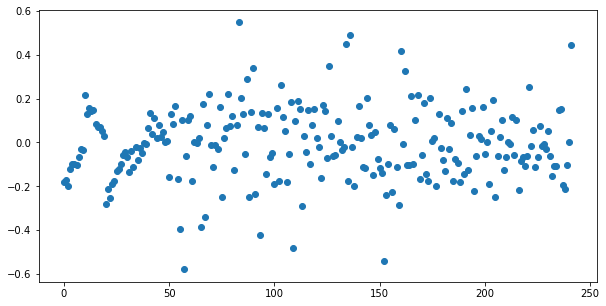

In [43]:
if do_manual_svc:
    coefs = model[1].coef_[0]
    plt.scatter(x=np.arange(len(coefs)), y=coefs)
    plt.show()


In [59]:
if do_manual_svc:
    model.fit(X, y.values.ravel(),
              linearsvc__sample_weight=weights.values.ravel())
    confidences = model.decision_function(X)
    print(f"Scores for last games={model.score(X_chrono_test, y_chrono_test.values.ravel(), weight_chrono_test.values.ravel())}")
    print(f"Scores for test games={model.score(X_test, y_test.values.ravel(), weight_test.values.ravel())}")


Scores for last games=0.6444868161575531
Scores for test games=0.7345201483783013


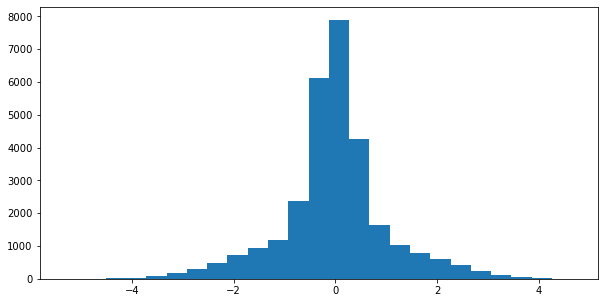

In [60]:
if do_manual_svc:
    plt.hist(confidences, bins=25)
    plt.show()


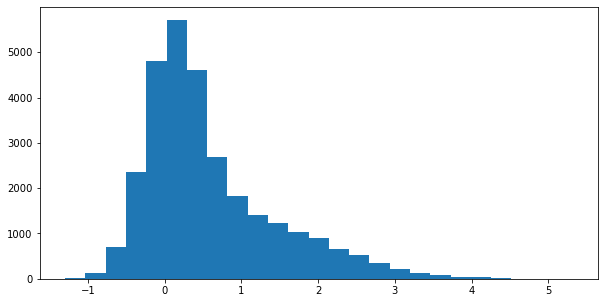

In [61]:
if do_manual_svc:
    plt.hist(confidences * (2 * y.to_numpy().ravel() - 1), bins=25)
    plt.show()


In [62]:
if do_manual_svc:
    np.min(confidences * (2 * y.to_numpy().ravel() - 1))


In [63]:
if do_catboost:
    catboost_model = CatBoostClassifier(
        custom_loss=[metrics.Accuracy()],
        random_seed=0xdeadbeef,
        logging_level='Silent',
        task_type='GPU' if use_gpu else 'CPU'
    )

    catboost_model.fit(
        X_cv, y_cv,sample_weight=weight_cv,
        cat_features=categorical_columns_indices,
        eval_set=(X_test, y_test),
        early_stopping_rounds=100,
        plot=True
    )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [65]:
if do_catboost:
    data_pool = Pool(X_cv, y_cv, cat_features=categorical_columns_indices, weight=weight_cv)
    cv_params = catboost_model.get_params()
    cv_params.update({
        'loss_function': metrics.Logloss()
    })
    cv_data = cv(
        data_pool,
        cv_params,
        plot=True,
        early_stopping_rounds=100
    )


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
if do_catboost:
    print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
        np.max(cv_data['test-Accuracy:use_weights=true-mean']),
        cv_data['test-Accuracy:use_weights=true-std'][np.argmax(cv_data['test-Accuracy:use_weights=true-mean'])],
        np.argmax(cv_data['test-Accuracy:use_weights=true-mean'])
    ))
    print()
    
    feature_importances = catboost_model.get_feature_importance(data_pool)
    feature_names = X_train.columns
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
        print('{}: {}'.format(name, score))


Best validation accuracy score: 0.78±0.00 on step 375

Opponent Code_p_Score Diff: 9.695217603508873
Team Code_pp_Score Diff: 9.072261296154604
Opponent Code_pp_Score Diff: 8.254155750825893
Opponent Code_pp_Pct Team Score: 7.668378168558619
Team Code_pp_Pct Team Score: 7.260842715576316
Team Code_p_Pct Opponent Score: 6.913938232467505
Team Code_pppp_Pct Opponent Score: 5.153241482959179
Team Code_p_Score Diff: 4.389905788312615
Opponent Code: 3.9610834122196383
Team Code: 3.8140139662335537
Opponent Code_p_Pct Opponent Score: 3.7259866739940186
Team Code_ppp_Score Diff: 3.343330573977052
Opponent Code_pp_Home/Away: 3.2399019528475783
Opponent Code_p_Home/Away: 3.024923717456267
Team Code_p_Pct Team Score: 2.75287098936263
Team Code_pp_Pct Opponent Score: 2.100806761394394
Opponent Code_ppp_Pct Opponent Score: 1.9762646942533906
Opponent Code_pppp_Pct Team Score: 1.927820307708114
Opponent Code_pppp_Pct Opponent Score: 1.8310854207770466
Team Code_ppp_Pct Team Score: 1.700517708038691

Scores for last 5% of games=0.6864516129032258


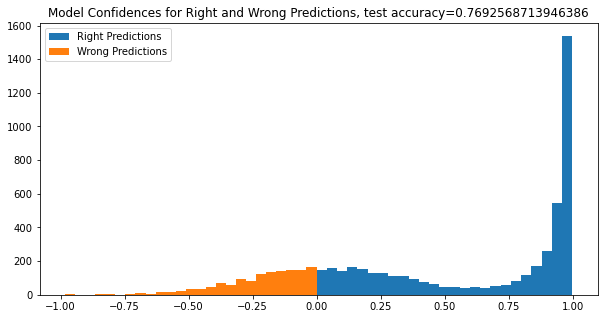

In [67]:
if do_catboost:
    confidences = catboost_model.predict_proba(X_test)
    confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
    wrong_preds = confidences[confidences < 0]
    right_preds = confidences[confidences > 0]
    print(f"Scores for last 5% of games={catboost_model.score(X_chrono_test, y_chrono_test)}")
    plt.title(f'Model Confidences for Right and Wrong Predictions, test accuracy={catboost_model.score(X_test, y_test.values.ravel())}')
    plt.hist(right_preds, bins=25, label='Right Predictions')
    plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
    plt.legend()
    plt.show()


Train accuracy=0.9469285593076532
Scores for last 5% of games=0.6800551122487626


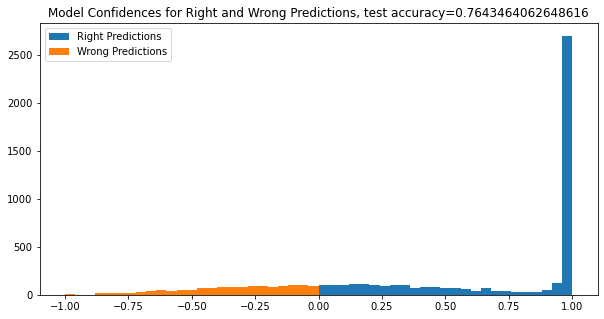

In [68]:
if do_xgboost:
  xgboost_model = make_pipeline(dataset_transformer(),xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss'))
  xgboost_model.fit(X_cv, y_cv.values.ravel(), xgbclassifier__sample_weight=weight_cv.values.ravel())
  print(f'Train accuracy={xgboost_model.score(X_cv, y_cv.values.ravel())}')
  
  confidences = xgboost_model.predict_proba(X_test)
  confidences = (2*np.max(confidences, axis=1)-1) * (2*np.argmax(confidences, axis=1) - 1) * (2 * y_test.values.ravel() - 1)
  wrong_preds = confidences[confidences < 0]
  right_preds = confidences[confidences > 0]
  print(f"Scores for last 5% of games={xgboost_model.score(X_chrono_test, y_chrono_test.values.ravel(), weight_chrono_test.values.ravel())}")
  plt.title(f'Model Confidences for Right and Wrong Predictions, test accuracy={xgboost_model.score(X_test, y_test.values.ravel(), weight_test.values.ravel())}')
  plt.hist(right_preds, bins=25, label='Right Predictions')
  plt.hist(wrong_preds, bins=25, label='Wrong Predictions')
  plt.legend()
  plt.show()

In [69]:
odds_data = pd.read_csv(os.path.join(basedir, 'data', 'derived', 'odds_portal_clean.csv'))
odds_data = odds_data.loc[odds_data['Special Game'].str.contains('All Stars').isna(),:]

odds_data['Date'] = pd.to_datetime(odds_data['Date'])
odds_data['Home Score'] = pd.to_numeric(odds_data['Home Score'])
odds_data['Away Score'] = pd.to_numeric(odds_data['Away Score'].str.strip())

odds_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3414 entries, 0 to 4328
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Season        3414 non-null   object        
 1   Date          3414 non-null   datetime64[ns]
 2   Special Game  0 non-null      object        
 3   Time          3414 non-null   object        
 4   Home Team     3414 non-null   object        
 5   Away Team     3414 non-null   object        
 6   Home Score    3414 non-null   int64         
 7   Away Score    3414 non-null   int64         
 8   OT            3414 non-null   bool          
 9   Winner        3414 non-null   object        
 10  Home Odds     3414 non-null   object        
 11  Away Odds     3414 non-null   object        
 12  B's           3414 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(8)
memory usage: 350.1+ KB


In [70]:
teams_and_codes = cleaned_matches.groupby(['Team', 'Team Code']).count().index.to_series().reset_index(level=1).drop(columns=[0])
opponents_and_codes = cleaned_matches.groupby(['Opponent', 'Opponent Code']).count().index.to_series().reset_index(level=1).drop(columns=[0])
teams_and_codes.columns = ['Code']
opponents_and_codes.columns = ['Code']

In [71]:
team_to_code = pd.concat([teams_and_codes, opponents_and_codes])
team_to_code.head()

,Code
Akron Indians,akr
Akron Pros,akr
Arizona Cardinals,ari
Arizona Cardinals,lari
Atlanta Falcons,atl


In [72]:
odds_data['Home Code'] = team_to_code.loc[odds_data['Home Team'].str.strip().to_list(), 'Code'].reset_index(drop=True)
odds_data['Away Code'] = team_to_code.loc[odds_data['Away Team'].str.strip().to_list(), 'Code'].reset_index(drop=True)
odds_data.head()

,Season,Date,Special Game,Time,Home Team,Away Team,Home Score,Away Score,OT,Winner,Home Odds,Away Odds,B's,Home Code,Away Code
0,2021/22,2021-11-16,NaN,1:15,San Francisco 49ers,Los Angeles Rams,31,10,False,Home,158,-182,13,lsf,larm
1,2021/22,2021-11-15,NaN,1:20,Las Vegas Raiders,Kansas City Chiefs,14,41,False,Away,129,-149,13,sf,llarm
2,2021/22,2021-11-14,NaN,21:25,Denver Broncos,Philadelphia Eagles,13,30,False,Away,-106,-110,13,sf,larm
3,2021/22,2021-11-14,NaN,21:25,Green Bay Packers,Seattle Seahawks,17,0,False,Home,-172,149,13,llv,kc
4,2021/22,2021-11-14,NaN,21:05,Arizona Cardinals,Carolina Panthers,10,34,False,Away,-323,265,13,den,lkc


In [73]:
pertinent_cols = [
    'Date',
    'Home Score',
    'Away Score',
    'Home Odds',
    'Away Odds',
    'Home Code',
    'Away Code'
]

odds_as_teams = odds_data.loc[:, pertinent_cols]
odds_as_opponents = odds_data.loc[:, pertinent_cols]

odds_as_teams.columns = [col.replace('Home', 'Team').replace(
    'Away', 'Opponent') for col in pertinent_cols]
odds_as_opponents.columns = [col.replace('Home', 'Opponent').replace(
    'Away', 'Team') for col in pertinent_cols]

odds_as_teams['Home/Away'] = 'H'
odds_as_opponents['Home/Away'] = 'A'

odds_as_matches = pd.concat([odds_as_teams, odds_as_opponents]).sort_values(
    'Date', ascending=True)

odds_as_matches['Weight'] = (odds_as_matches['Date'].dt.year - oldest_match_year
                             ) if use_years_as_weights else np.ones(odds_as_matches['Date'].shape)

odds_as_matches = odds_as_matches.drop(columns='Date').reset_index(drop=True)

odds_as_matches.head()


,Team Score,Opponent Score,Team Odds,Opponent Odds,Team Code,Opponent Code,Home/Away,Weight
0,17,23,-286,246,hou,ten,H,88
1,21,30,150,-169,cin,lpit,H,88
2,16,13,-200,174,cle,pit,H,88
3,10,13,112,-127,lcle,pit,H,88
4,34,0,-455,371,cle,lwas,H,88


In [74]:
score_sum = odds_as_matches['Team Score'] + odds_as_matches['Opponent Score']
odds_as_matches['Pct Team Score'] = odds_as_matches['Team Score'] / score_sum
odds_as_matches['Pct Opponent Score'] = odds_as_matches['Opponent Score'] / score_sum

odds_as_matches['Score Diff'] = odds_as_matches['Team Score'] - \
    odds_as_matches['Opponent Score']

odds_as_matches['Class'] = pd.to_numeric(
    odds_as_matches['Team Score'] > odds_as_matches['Opponent Score']) * 1

odds_as_matches.head()


,Team Score,Opponent Score,Team Odds,Opponent Odds,Team Code,Opponent Code,Home/Away,Weight,Pct Team Score,Pct Opponent Score,Score Diff,Class
0,17,23,-286,246,hou,ten,H,88,0.425000,0.575000,-6,0
1,21,30,150,-169,cin,lpit,H,88,0.411765,0.588235,-9,0
2,16,13,-200,174,cle,pit,H,88,0.551724,0.448276,3,1
3,10,13,112,-127,lcle,pit,H,88,0.434783,0.565217,-3,0
4,34,0,-455,371,cle,lwas,H,88,1.000000,0.000000,34,1


In [75]:
last_n_matches, new_columns = form_last_n_games(
    odds_as_matches, 5, lookup_x_cols, key_x_cols)

.................................................
 Done


In [76]:
X_odds = pd.concat([last_n_matches[x_cols], last_n_matches[new_columns]], axis=1)
y_odds = last_n_matches[y_cols]

odds = last_n_matches.loc[:, ['Team Odds','Opponent Odds']]
odds['Team Odds'] = pd.to_numeric(odds['Team Odds'])
odds['Opponent Odds'] = pd.to_numeric(odds['Opponent Odds'])

weights = odds_as_matches[weight_cols].loc[last_n_matches.index, :]

numeric_columns = X_odds.columns[X_odds.columns.str.contains('Score')]
categorical_columns = X_odds.columns[~X_odds.columns.str.contains('Score')]
categorical_columns_indices = np.where(~X_odds.columns.str.contains('Score'))[0]

print(categorical_columns)
print(categorical_columns_indices)
print(numeric_columns)
print(weights)


Index(['Team Code', 'Opponent Code', 'Home/Away', 'Team Code_p_Home/Away',
       'Opponent Code_p_Home/Away', 'Team Code_pp_Home/Away',
       'Opponent Code_pp_Home/Away', 'Team Code_ppp_Home/Away',
       'Opponent Code_ppp_Home/Away', 'Team Code_pppp_Home/Away',
       'Opponent Code_pppp_Home/Away', 'Team Code_ppppp_Home/Away',
       'Opponent Code_ppppp_Home/Away'],
      dtype='object')
[ 0  1  2 53 54 55 56 57 58 59 60 61 62]
Index(['Team Code_p_Team Score', 'Opponent Code_p_Team Score',
       'Team Code_pp_Team Score', 'Opponent Code_pp_Team Score',
       'Team Code_ppp_Team Score', 'Opponent Code_ppp_Team Score',
       'Team Code_pppp_Team Score', 'Opponent Code_pppp_Team Score',
       'Team Code_ppppp_Team Score', 'Opponent Code_ppppp_Team Score',
       'Team Code_p_Opponent Score', 'Opponent Code_p_Opponent Score',
       'Team Code_pp_Opponent Score', 'Opponent Code_pp_Opponent Score',
       'Team Code_ppp_Opponent Score', 'Opponent Code_ppp_Opponent Score',
       

In [190]:
def preds_to_confidences(preds):
    return np.array(2*np.max(preds, axis=1)-1) * (2*np.argmax(preds, axis=1) - 1).ravel()


def straight_bet_strategy(preds, odds, actual):
    confidences = preds_to_confidences(preds)
    odds_of_bet = np.where(
        confidences >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    results = (confidences * (2*actual.values.ravel() - 1)) > 0

    bids = np.ones(results.shape)
    winnings = payout_from_bid(bids, odds_of_bet, results)

    return winnings, bids


def proportional_bet_strategy(preds, odds, actual):
    confidences = preds_to_confidences(preds)
    odds_of_bet = np.where(
        confidences >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    results = (confidences * (2*actual.values.ravel() - 1)) > 0

    # Make integrated bid over confidences equal to straight, even though the distribution is not uniform
    bids = np.abs(confidences) + 1

    winnings = payout_from_bid(bids, odds_of_bet, results)

    return winnings, bids


def quadratic_proportional_bet_strategy(preds, odds, actual):
    confidences = preds_to_confidences(preds)
    odds_of_bet = np.where(
        confidences >= 0, odds['Team Odds'].values.ravel(), odds['Opponent Odds'].values.ravel())
    results = (confidences * (2*actual.values.ravel() - 1)) > 0

    # Make integrated bid over confidences equal to straight, even though the distribution is not uniform
    bids = np.square(np.abs(confidences)) + 2 - 2/3

    winnings = payout_from_bid(bids, odds_of_bet, results)

    return winnings, bids


def plot_bet_strategies(preds, odds, actual):
    straight_winnings, straight_bets = straight_bet_strategy(
        preds, odds, actual)
    proportional_winnings, proportional_bets = proportional_bet_strategy(
        preds, odds, actual)
    quadratic_winnings, quadratic_bets = quadratic_proportional_bet_strategy(
        preds, odds, actual)

    x = preds_to_confidences(preds)
    plt.scatter(x[straight_winnings != 0], straight_winnings[straight_winnings !=
                                                             0], label='Straight Bets Winnings', alpha=0.1, marker='.')
    plt.scatter(x[proportional_winnings != 0], proportional_winnings[proportional_winnings != 0],
                label='Proportional Bets Winnings', alpha=0.1, marker='.')
    plt.scatter(x[quadratic_winnings != 0], quadratic_winnings[quadratic_winnings !=
                                                               0], label='Quadratic Bets Winnings', alpha=0.1, marker='.')

    straight_losses = -straight_bets[straight_winnings == 0]
    proportional_losses = -proportional_bets[proportional_winnings == 0]
    quadratic_losses = -quadratic_bets[quadratic_winnings == 0]
    plt.scatter(x[straight_winnings == 0], straight_losses,
                label='Straight Bets Losses', alpha=0.1, marker='.')
    plt.scatter(x[proportional_winnings == 0], proportional_losses,
                label='Proportional Bets Losses', alpha=0.1, marker='.')
    plt.scatter(x[quadratic_winnings == 0], quadratic_losses,
                label='Quadratic Bets Losses', alpha=0.1, marker='.')

    plt.legend()
    plt.xlabel('Model Confidence')
    plt.ylabel('Payout')
    plt.title('Payout vs Losses for Three Strategies vs. Model Confidence')
    plt.show()

    net_straight = straight_winnings - straight_bets * (straight_winnings == 0)
    net_proportional = proportional_winnings - proportional_bets * (proportional_winnings == 0)
    net_quadratic = quadratic_winnings - quadratic_bets * (quadratic_winnings == 0)

    cols = ['Straight','Proportional','Quadratic']
    net_data = pd.DataFrame(data={'Straight':net_straight,'Proportional':net_proportional,'Quadratic':net_quadratic},index=x).sort_index()
    binned = net_data.groupby([pd.cut(net_data.index, 20)])[cols].sum().reset_index()
    binned.plot.bar(x='index',y=cols)
    plt.title('Net Payout for Three Strategies vs Model Confidence')
    plt.ylabel('Payout')
    plt.semilogy()
    plt.show()
    


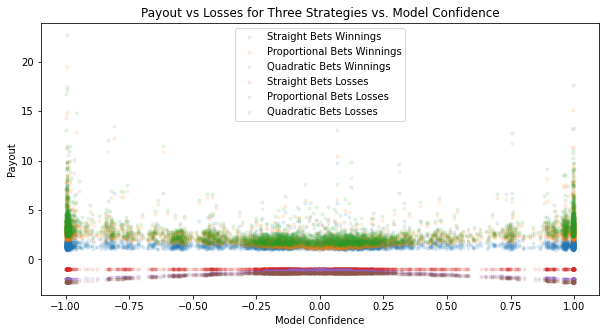

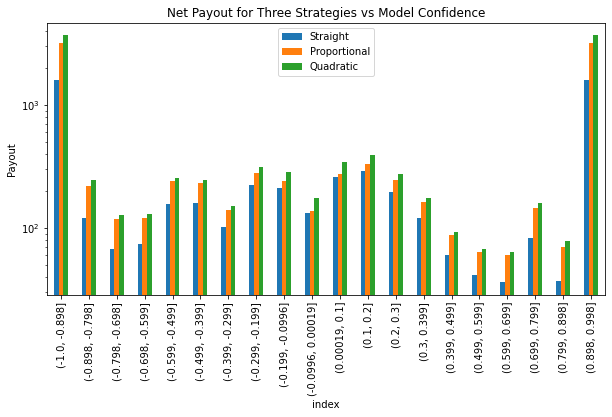

In [191]:
if do_manual_bagging:
    preds = bagging_model.predict_proba(X_odds)
    plot_bet_strategies(preds, odds, y_odds)


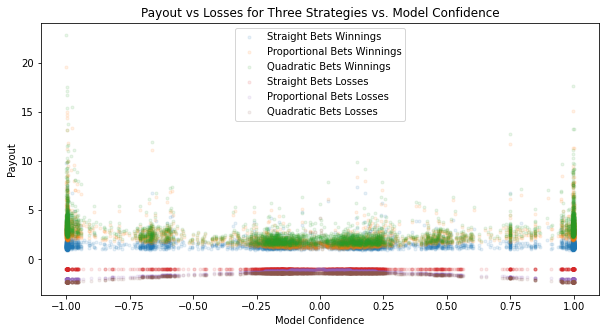

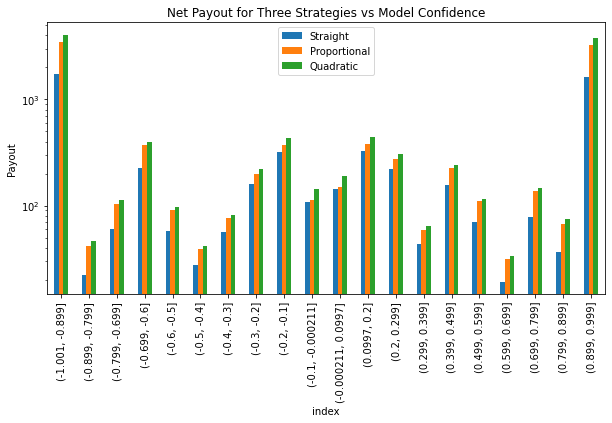

In [192]:

if do_sklearn_grid_tree:
    preds = grid_search_bag_tree.best_estimator_.predict_proba(X_odds)
    plot_bet_strategies(preds, odds, y_odds)


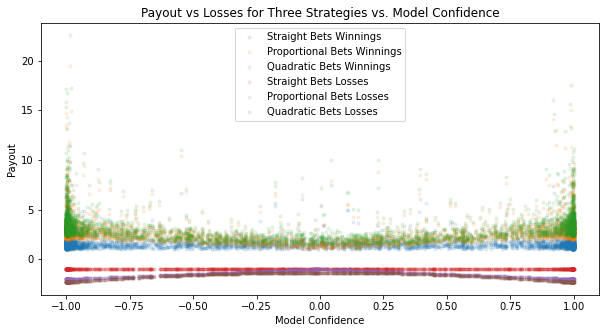

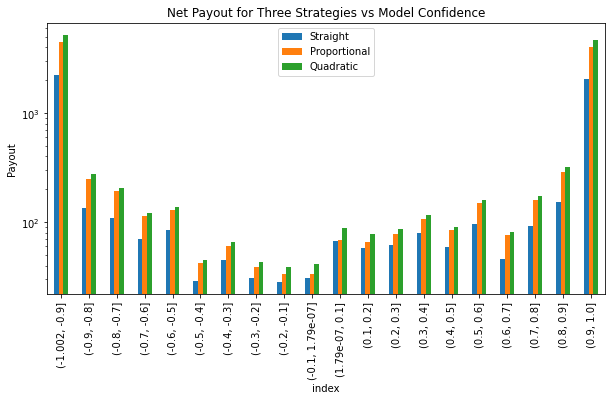

In [193]:

if do_xgboost:
    preds = xgboost_model.predict_proba(X_odds)
    plot_bet_strategies(preds, odds, y_odds)


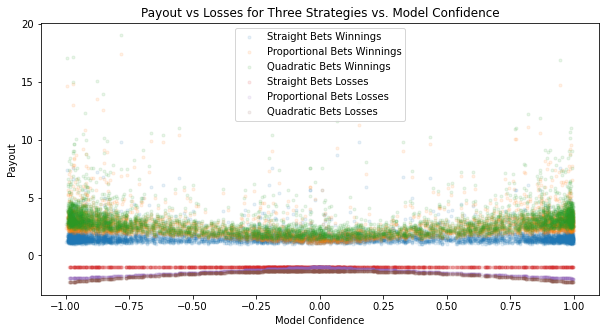

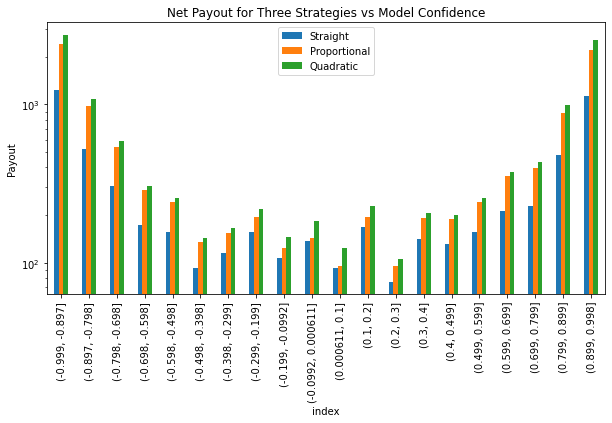

In [194]:

if do_catboost:
    preds = catboost_model.predict_proba(X_odds)
    plot_bet_strategies(preds, odds, y_odds)
